<a href="https://colab.research.google.com/github/LGuilhermeRodrigues/walk-recordings-filter/blob/main/walk_recordings_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualização

## Carregar os dados

### Subtask:
Carregar o arquivo CSV do URL fornecido em um DataFrame pandas.


In [66]:
import pandas as pd

base_url = "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/"
files = [
    "20220914-102032.csv",
    "F1_50_df.csv",
    "knee_angles_corrigidoF1_42.csv",
    "knee_angles_corrigidoF1_57.csv",
    "knee_angles_corrigidoF2_00.csv",
    "knee_angles_corrigidoF2_12.csv"
]
files_filter = [
    35,
    35,
    42,
    52,
    30,
    33
]

df = pd.read_csv(base_url + files[0])

Display the first few rows of the DataFrame to verify the data was loaded correctly.



In [67]:
df.head()

,time,Latitude,Longitude,shoulderLangle,shoulderRangle,shoulderLTransv,shoulderRTransv,elbowLangle,elbowRangle,hipLangle,...,l_kneeZ,r_kneeX,r_kneeY,r_kneeZ,l_ankleX,l_ankleY,l_ankleZ,r_ankleX,r_ankleY,r_ankleZ
0,102036,52.507613,13.390514,11,25,9,42,49,41,10,...,0.018,0.038,-0.404,-0.026,-0.190,-0.756,-0.070,0.007,-0.766,-0.133
1,102036,52.507613,13.390514,10,26,15,39,47,39,8,...,0.022,0.033,-0.404,-0.023,-0.189,-0.754,-0.063,-0.004,-0.769,-0.117
2,102036,52.507613,13.390514,10,26,15,38,47,39,8,...,0.024,0.032,-0.405,-0.023,-0.189,-0.751,-0.060,-0.007,-0.769,-0.116
3,102036,52.507613,13.390514,10,26,15,38,47,39,8,...,0.025,0.032,-0.405,-0.023,-0.189,-0.750,-0.059,-0.008,-0.770,-0.116
4,102036,52.507613,13.390514,10,27,17,38,48,39,8,...,0.025,0.032,-0.405,-0.023,-0.189,-0.750,-0.060,-0.008,-0.770,-0.117


## Visualizar os dados

### Subtask:
Criar um gráfico de linha com as colunas "kneeLangle" e "kneeRangle" do DataFrame.


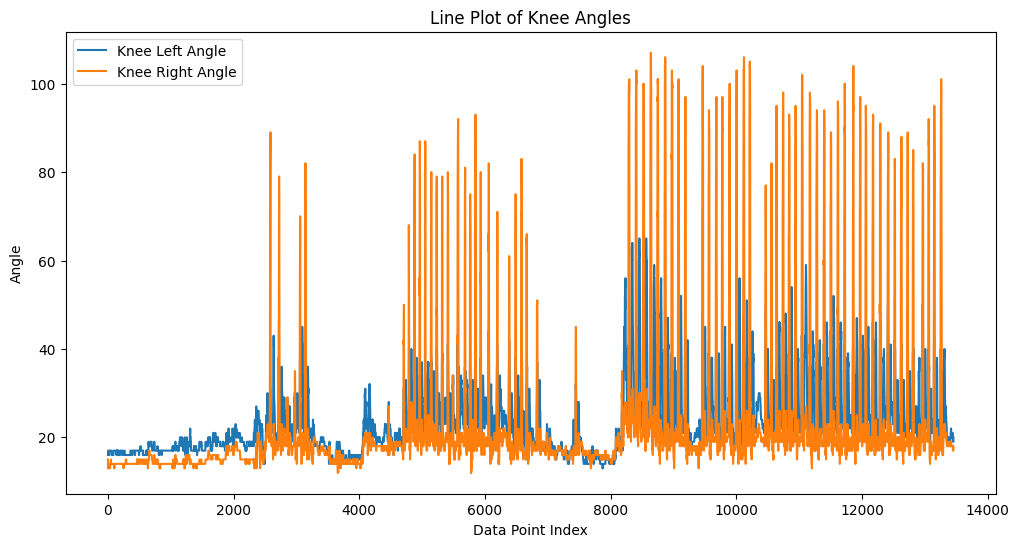

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['kneeLangle'], label='Knee Left Angle')
plt.plot(df['kneeRangle'], label='Knee Right Angle')
plt.title('Line Plot of Knee Angles')
plt.xlabel('Data Point Index')
plt.ylabel('Angle')
plt.legend()
plt.show()

# Task
Gere seis gráficos de linha a partir dos arquivos CSV localizados em "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/20220914-102032.csv", "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/F1_50_df.csv", "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/knee_angles_corrigidoF1_42.csv", "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/knee_angles_corrigidoF1_57.csv", "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/knee_angles_corrigidoF2_00.csv", "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/knee_angles_corrigidoF2_12.csv", exibindo as colunas "kneeLangle" e "kneeRangle" em cada gráfico.

## Carregar e visualizar dados

### Subtask:
Para cada arquivo, carregar os dados e gerar um gráfico de linha separado para as colunas "kneeLangle" e "kneeRangle".


**Reasoning**:
Iterate through the list of files, load each one into a DataFrame, and generate a line plot for 'kneeLangle' and 'kneeRangle'.



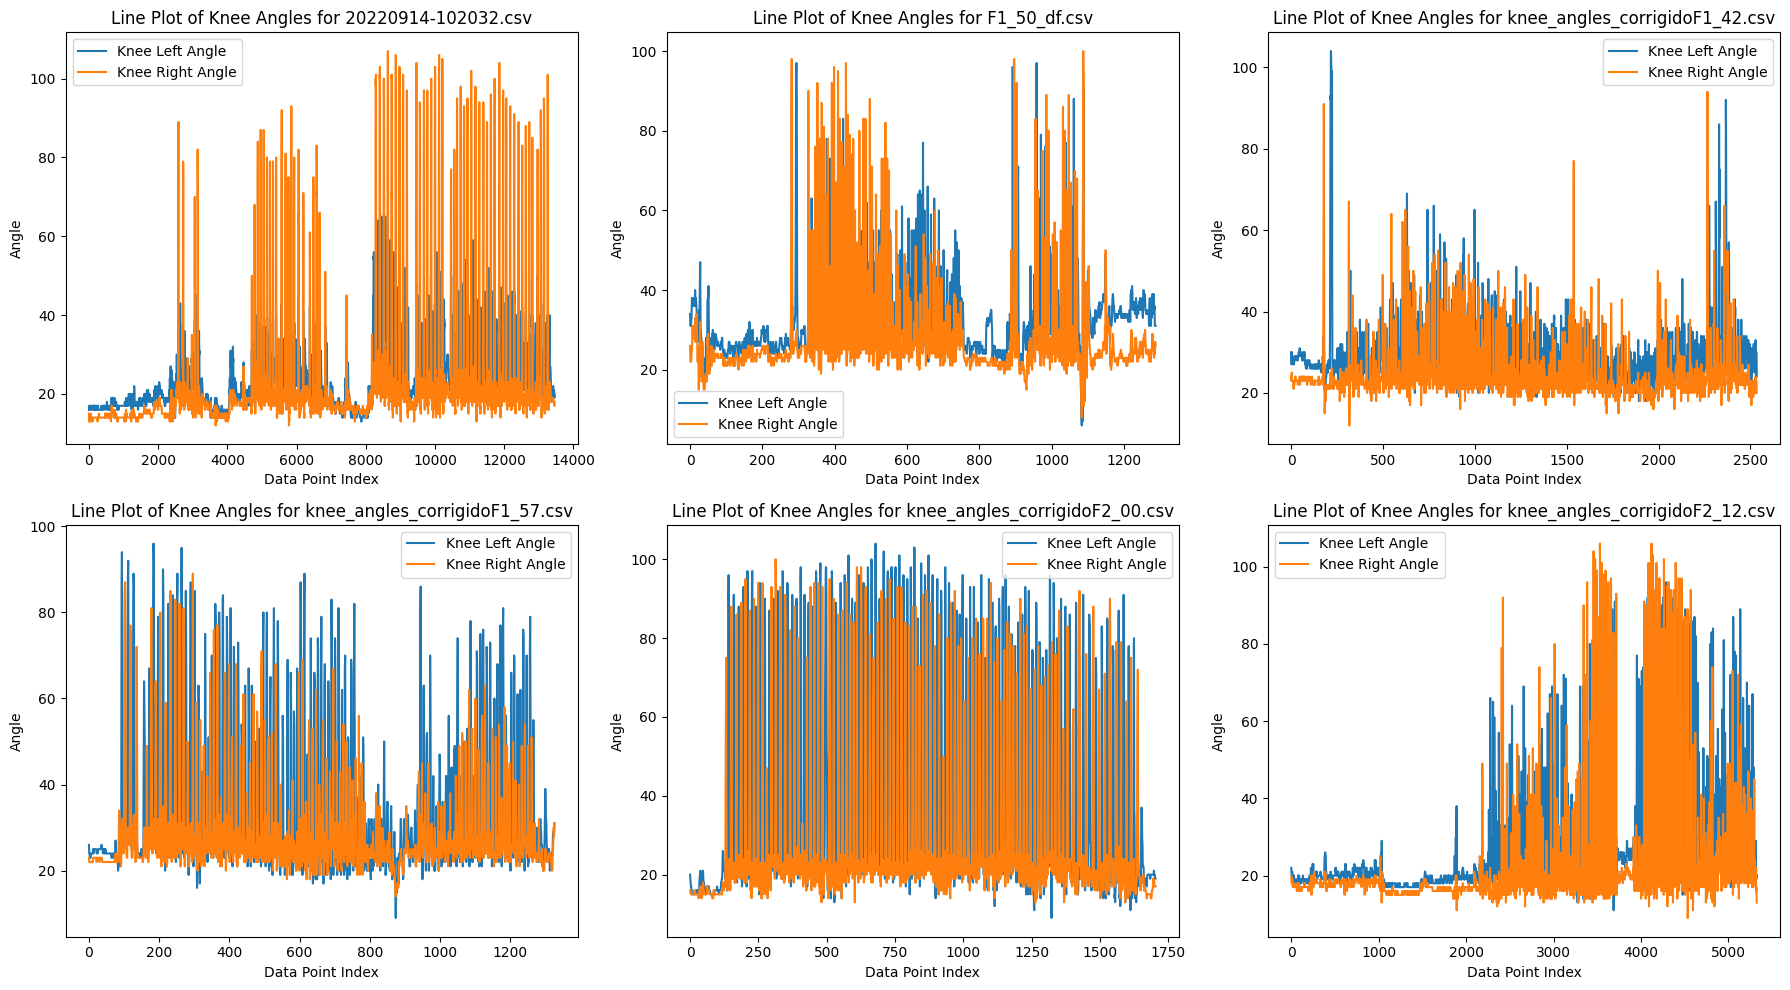

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, file in enumerate(files):
    file_url = base_url + file
    df = pd.read_csv(file_url)

    axes[i].plot(df['kneeLangle'], label='Knee Left Angle')
    axes[i].plot(df['kneeRangle'], label='Knee Right Angle')
    axes[i].set_title(f'Line Plot of Knee Angles for {file}')
    axes[i].set_xlabel('Data Point Index')
    axes[i].set_ylabel('Angle')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Task
Crie uma base_url = "https://raw.githubusercontent.com/LGuilhermeRodrigues/walk-recordings-filter/refs/heads/main/CSVs/" e uma lista com files = ["20220914-102032.csv", "F1_50_df.csv", "knee_angles_corrigidoF1_42.csv", "knee_angles_corrigidoF1_57.csv", "knee_angles_corrigidoF2_00.csv", "knee_angles_corrigidoF2_12.csv"]. Para cada arquivo na lista files, crie um novo dataframe filtrando a cada 50 linhas do dataframe original. Para um arquivo em files que tem seu respectivo filtro na lista files_filter, teste de 50 em 50 linhas se em alguma dessas linhas tem esse valor, se tiver, copie a linha para o novo dataframe.

## Iterar sobre arquivos e filtros

### Subtask:
Percorrer a lista de arquivos e seus filtros correspondentes.


**Reasoning**:
Initialize an empty list to store filtered dataframes and iterate through the files and filters lists.



In [70]:
filtered_dfs = []
for i, file in enumerate(files):
    file_url = base_url + file
    filter_value = files_filter[i]
    df = pd.read_csv(file_url)
    filtered_df = pd.DataFrame()
    row_step = 100
    for j in range(0, len(df), row_step):
        fifty_rows = df.iloc[j:j+row_step]
        if (fifty_rows['kneeLangle'] == filter_value).any() or (fifty_rows['kneeRangle'] == filter_value).any():
            filtered_df = pd.concat([filtered_df, fifty_rows])
        else:
            pass
            #filtered_df = pd.concat([filtered_df, fifty_rows])
    filtered_df.insert(0, 'new_index', range(len(filtered_df)))
    filtered_dfs.append(filtered_df)

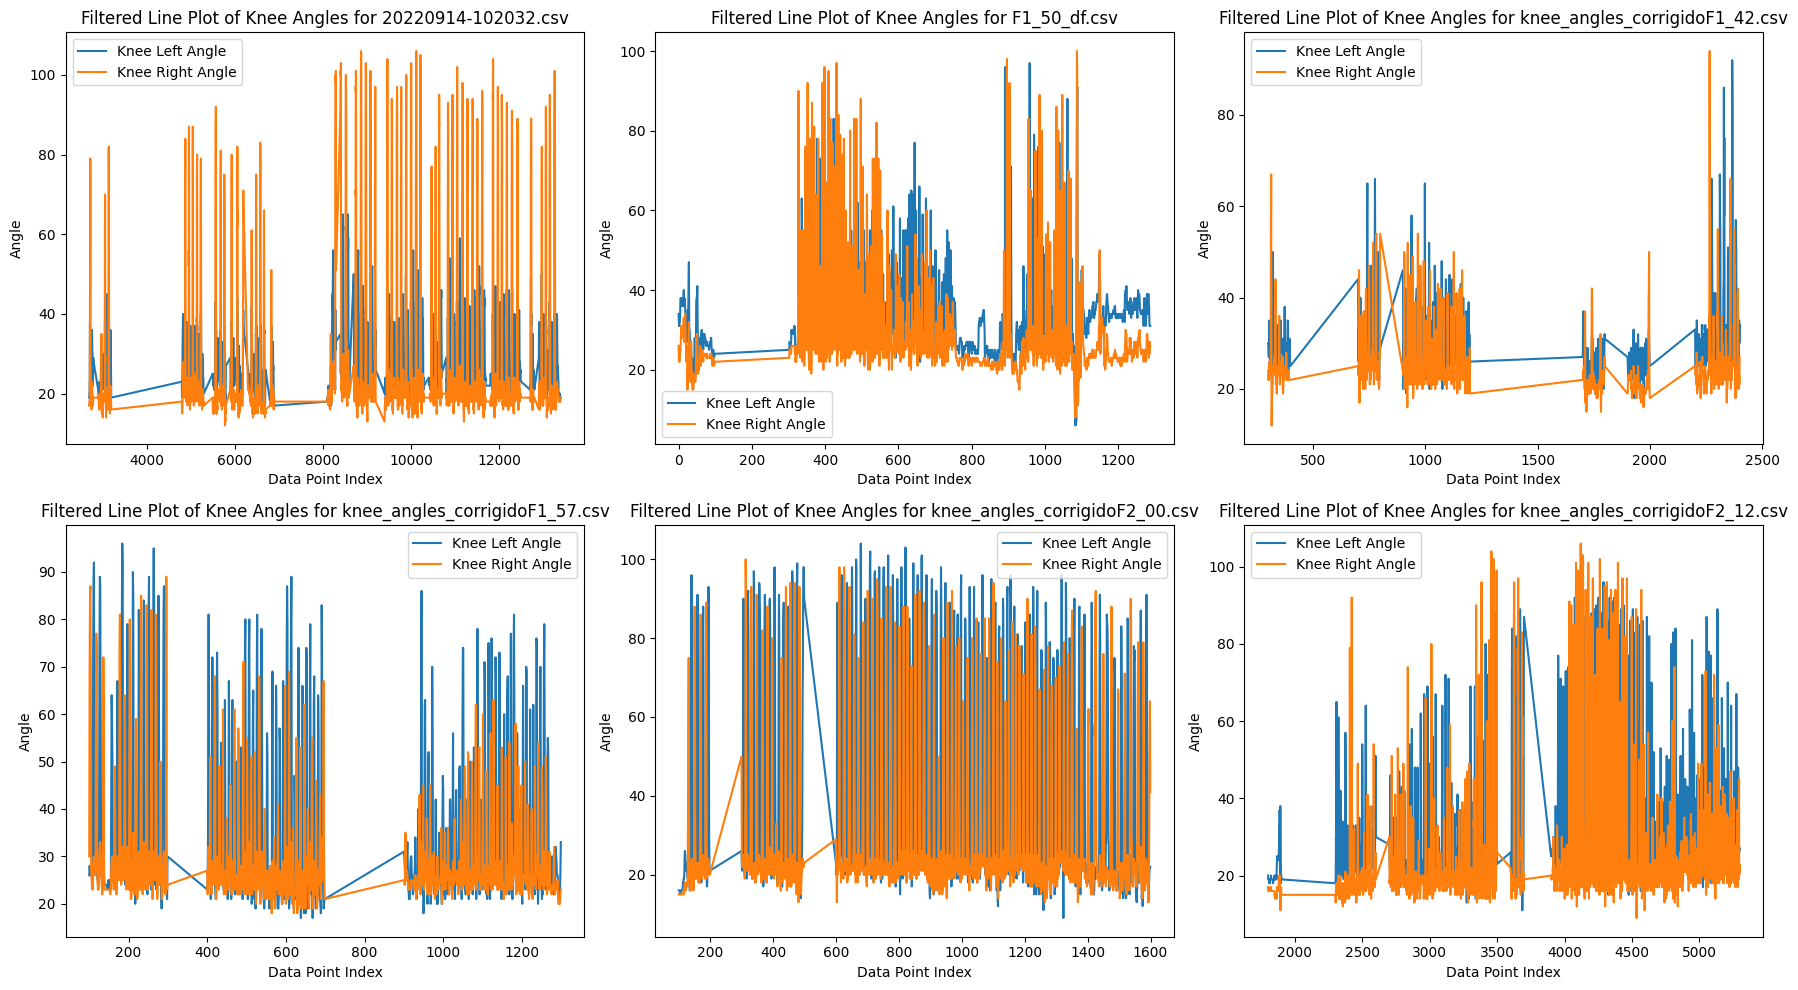

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, filtered_df in enumerate(filtered_dfs):
    axes[i].plot(filtered_df['kneeLangle'], label='Knee Left Angle')
    axes[i].plot(filtered_df['kneeRangle'], label='Knee Right Angle')
    axes[i].set_title(f'Filtered Line Plot of Knee Angles for {files[i]}')
    axes[i].set_xlabel('Data Point Index')
    axes[i].set_ylabel('Angle')
    axes[i].legend()

plt.tight_layout()
plt.show()